# House Keeping

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

torch.backends.cudnn.benchmark=True

torch.cuda.is_available()

True

In [2]:
nw = 6

PATH = './'
TRAIN = 'data/train/'
TEST = 'data/test/'
LABELS = 'data/train.csv'
SAMPLE = 'data/sample_submission.csv'

In [3]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [4]:
def open_rgby(path,id): 
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

# Data Objects

In [6]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [7]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

### New Stratified Folds

In [8]:
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import _num_samples, check_array

In [9]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import gc

train_folds = []
val_folds = []
folds = 5

def make_folds():
    msss = MultilabelStratifiedShuffleSplit(n_splits=folds, test_size=0.2, random_state=42)
    train_df = pd.read_csv(LABELS)
    train_df_orig = train_df.copy()
    train_df_orig['Target'] = [[int(i) for i in s.split()] for s in train_df_orig['Target']]
    X = train_df_orig['Id'].tolist()
    y = train_df_orig['Target'].tolist()
    y = MultiLabelBinarizer().fit_transform(y)

    for train_index, test_index in msss.split(X,y): #it should only do one iteration
        print("TRAIN:", train_index, "TEST:", test_index)
        train_folds.append(train_df_orig.loc[train_df_orig.index.intersection(train_index)].copy())
        val_folds.append(train_df_orig.loc[train_df_orig.index.intersection(test_index)].copy())
        
    for k in range(folds):
        train_folds[k]['Target'] = [[str(i) for i in s] for s in train_folds[k]['Target']]
        train_folds[k]['Target'] = train_folds[k]['Target'].apply(', '.join)
        
        val_folds[k]['Target'] = [[str(i) for i in s] for s in val_folds[k]['Target']]
        val_folds[k]['Target'] = val_folds[k]['Target'].apply(', '.join)
        
        train_folds[k].to_csv(f'data/new5_fold/trn_folds_{k}')
        val_folds[k].to_csv(f'data/new5_fold/val_folds_{k}')
    
gc.collect()

7

In [10]:
def load_folds():
    for i in range(folds):
        train_folds.append(pd.read_csv(f'data/new5_fold/trn_folds_{i}'))
        val_folds.append(pd.read_csv(f'data/new5_fold/val_folds_{i}'))
        print(len(train_folds[i]), len(val_folds[i]))

In [11]:
# make_folds()
load_folds()

24837 6235
24874 6198
24828 6244
24881 6191
24898 6174


### Stratified Folds

In [8]:
from sklearn.model_selection import StratifiedKFold

folds = 5
train_folds = []
val_folds = []

def make_folds():
    skf = StratifiedKFold(n_splits=folds, random_state=33, shuffle=True)
    
    train_names = list({f[:36] for f in os.listdir(TRAIN)})
    test_names = list({f[:36] for f in os.listdir(TEST)})
    trn_df = pd.read_csv('data/train.csv')
    
    for train_index, evaluate_index in skf.split(trn_df.index.values, trn_df.Target):
        trn_value = trn_df.iloc[train_index]
        val_value = trn_df.iloc[evaluate_index]
        train_folds.append(trn_value)
        val_folds.append(val_value)
        print(train_index.shape, evaluate_index.shape)
    
    for i in range(folds):
        train_folds[i].to_csv(f'data/5_fold/trn_folds_{i}')
        val_folds[i].to_csv(f'data/5_fold/val_folds_{i}')

def load_folds():
    for i in range(folds):
        train_folds.append(pd.read_csv(f'data/5_fold/trn_folds_{i}'))
        val_folds.append(pd.read_csv(f'data/5_fold/val_folds_{i}'))
        print(len(train_folds[i]), len(val_folds[i]))

In [9]:
# make_folds()
load_folds()

24673 6399
24836 6236
24710 6362
24997 6075
25072 6000


### Over sampling

In [10]:
from sklearn.model_selection import StratifiedKFold

folds = 5
over_train_folds = []
over_val_folds = []

def make_over_folds():
    skf = StratifiedKFold(n_splits=folds, random_state=33, shuffle=True)
    
    trn_df = pd.read_csv('data/train.csv')
    unique = trn_df.drop_duplicates('Target')
    uniquex50 = pd.concat([unique]*50)
    
    for train_index, evaluate_index in skf.split(trn_df.index.values, trn_df.Target):
        trn_value = trn_df.iloc[train_index]
        val_value = trn_df.iloc[evaluate_index]
        
        over_train_folds.append(trn_value)
        over_val_folds.append(val_value)
        print(train_index.shape, evaluate_index.shape)
    
    for k in range(folds):
        trn_fold_frame = over_train_folds[k].copy()
        val_fold_frame = over_val_folds[k].copy()
        
        trn_unique = trn_fold_frame[~trn_fold_frame['Target'].duplicated(keep=False)]
        val_unique = val_fold_frame[~val_fold_frame['Target'].duplicated(keep=False)]
        
        over_train_folds[k] = pd.concat([trn_fold_frame, uniquex50], ignore_index=True)
        over_val_folds[k] = pd.concat([val_fold_frame], ignore_index=True)
        
    for i in range(folds):
        over_train_folds[i].to_csv(f'data/5_fold/allsparse_oversample/trn_folds_{i}')
        over_val_folds[i].to_csv(f'data/5_fold/allsparse_oversample/val_folds_{i}')

def load_over_folds():
    for i in range(folds):
        over_train_folds.append(pd.read_csv(f'data/5_fold/allsparse_oversample/trn_folds_{i}'))
        over_val_folds.append(pd.read_csv(f'data/5_fold/allsparse_oversample/val_folds_{i}'))

In [11]:
make_over_folds()

/home/eigenstir/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


(24673,) (6399,)
(24836,) (6236,)
(24710,) (6362,)
(24997,) (6075,)
(25072,) (6000,)


In [12]:
# load_over_folds()

In [13]:
for i in range(folds):
    print(len(over_train_folds[i]))
    print(len(over_val_folds[i]))

53773
6399
53936
6236
53810
6362
54097
6075
54172
6000


# Loss Functions

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,thresh=0.0):
    preds = (preds > thresh).int()
    targs = targs.int()
    return (preds==targs).float().mean()

def f1_loss(y_true, y_pred):
    epsilon = 1e-7
    y_pred = torch.sigmoid(y_pred)
    y_true = y_true.type(torch.FloatTensor).cuda()
    tp = torch.sum(y_true*y_pred)
    tn = torch.sum((1-y_true)*(1-y_pred))
    fp = torch.sum((1-y_true)*y_pred)
    fn = torch.sum((y_true*(1-y_pred)))
    
    p = tp / (tp + fp + epsilon)
    r = tp / (tp + fn + epsilon)
    f1 = 2*p*r / (p+r+epsilon)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 2 - torch.mean(f1)

def f1_metric(y_true, y_pred):
    y_pred = torch.sigmoid(y_pred)
    y_true = y_true.type(torch.FloatTensor).cuda()
    score = torch.sum(2.0*(y_pred*y_true))/torch.sum((y_pred+y_true) + 1e-7)
    return score

def f1_metric_draft(y_true, y_pred):
    epsilon = 1e-7
    y_pred = torch.sigmoid(y_pred)
    y_true = y_true.type(torch.FloatTensor).cuda()
    tp = torch.sum(y_true*y_pred)
    tn = torch.sum((1-y_true)*(1-y_pred))
    fp = torch.sum((1-y_true)*y_pred)
    fn = torch.sum((y_true*(1-y_pred)))
    
    p = tp / (tp + fp + epsilon)
    r = tp / (tp + fn + epsilon)
    f1 = 2*p*r / (p+r+epsilon)
    return f1

# Model

## Conv Base

In [13]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)
        n_fc = len(self.xtra_fc)+1
#         n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

## SE Definitions

In [14]:
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride



class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [15]:
class SEnetBuilder(ConvnetBuilder_custom):
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 8,6
        cut-=xtra_cut
        layers = cut_model(f(), 5)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        #####################################################
        w = layers[0].conv1.weight
        w1 = layers[0].conv1.weight[:,0].unsqueeze(dim=1)
        layers[0].conv1 = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].conv1.weight = torch.nn.Parameter(torch.cat((w,w1),dim=1))
        #####################################################
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
#         if not custom_head: layers += [nn.AvgPool2d(7, stride=1)]
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)
        
        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

#     def create_fc_layer(self, ni, nf, p, actn=None):
#         res=[]
#         if p: res.append(nn.Dropout(p=p))
#         res.append(nn.Linear(in_features=ni, out_features=nf))
#         if actn: res.append(actn)
#         return res

#     def get_fc_layers(self):
#         res=[]
# #         res=[nn.BatchNorm1d(num_features=ni)]
#         ni=self.nf
# #         for i,nf in enumerate(self.xtra_fc):
# #             res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
# #             ni=nf
#         final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
#         if self.is_reg: final_actn = None
#         res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
#         return res

class SENetLearner(ConvLearner):
        @classmethod
        def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
            models = SEnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
            return cls(data, models, precompute, **kwargs)

## Model Functions

In [16]:
def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [17]:
def get_fold(sz, bs, k):
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    
    trn_x = list(train_folds[k]['Id'])
    val_x = list(val_folds[k]['Id'])
    
    if len(trn_x)%bs == 0:
        ds = ImageData.get_ds(pdFilesDataset, (trn_x,TRAIN), 
                (val_x,TRAIN), tfms, test=(test_names,TEST))
    else:
        ds = ImageData.get_ds(pdFilesDataset, (trn_x[:-(len(trn_x)%bs)],TRAIN), 
                (val_x,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [18]:
def get_senet_model(md):
    learn = SENetLearner.pretrained(senet154, md, ps=0.2, xtra_fc=None) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc, f1_metric_draft]
    return learn 

In [19]:
def get_fold_model(sz, bs, k):
    md = get_fold(sz,bs,k)
    learn = get_senet_model(md)
    learn.freeze_to(1)
    return learn

In [20]:
sz = 256
bs = 16
k = 3
nw = 6
learn = get_fold_model(sz,bs,k)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [21]:
learn.model

Sequential(
  (0): Sequential(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256, kern

### Tuning Learning Rates

In [48]:
learn = get_fold_model(sz,bs,k)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [64]:
learn.lr_find()

 71%|███████   | 1105/1562 [04:54<02:01,  3.76it/s, loss=5.9] 

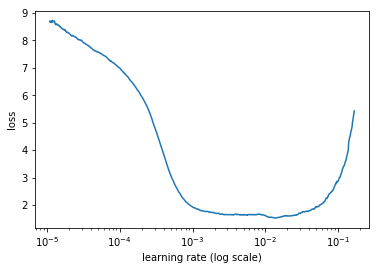

In [65]:
learn.sched.plot()

In [66]:
learn.lr_find2()

  5%|▌         | 85/1562 [00:52<15:18,  1.61it/s, loss=19]  

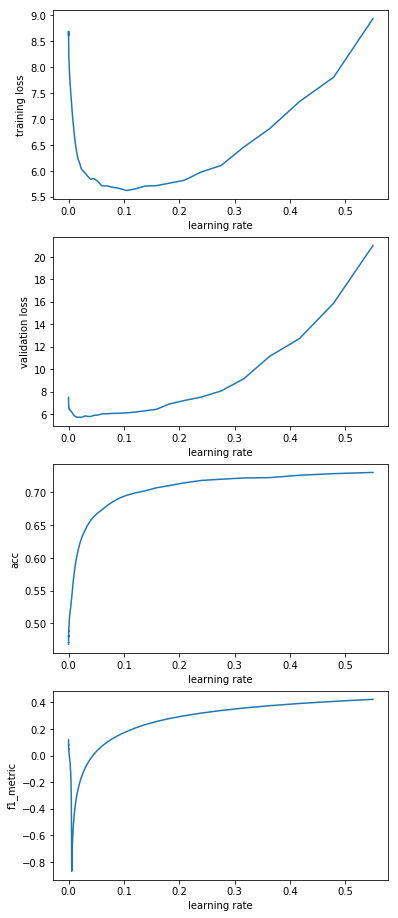

In [67]:
learn.sched.plot()

### Tuning Weight Decay

In [54]:
start_lr = 1e-3

In [55]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1e-7,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw7 = learn.sched.losses
val_lossesw7 = learn.sched.val_losses
lrsw7 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  4%|▍         | 62/1562 [00:38<15:22,  1.63it/s, loss=16.5]

In [56]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1e-6,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw6 = learn.sched.losses
val_lossesw6 = learn.sched.val_losses
lrsw6 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  4%|▍         | 61/1562 [00:38<15:49,  1.58it/s, loss=15.4] 

In [57]:

learn.lr_find2(wds=1e-5,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw5 = learn.sched.losses
val_lossesw5 = learn.sched.val_losses
lrsw5 = learn.sched.lrs

  4%|▍         | 61/1562 [00:39<16:01,  1.56it/s, loss=15.6]

In [58]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1e-4,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw4 = learn.sched.losses
val_lossesw4 = learn.sched.val_losses
lrsw4 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  4%|▍         | 62/1562 [00:39<16:03,  1.56it/s, loss=13.8] 

In [59]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1e-3,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw3 = learn.sched.losses
val_lossesw3 = learn.sched.val_losses
lrsw3 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  4%|▍         | 65/1562 [00:42<16:23,  1.52it/s, loss=11.7] 

In [60]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1e-2,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw2 = learn.sched.losses
val_lossesw2 = learn.sched.val_losses
lrsw2 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  4%|▍         | 66/1562 [00:42<16:04,  1.55it/s, loss=14.5]

In [61]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1e-1,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw1 = learn.sched.losses
val_lossesw1 = learn.sched.val_losses
lrsw1 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  5%|▍         | 74/1562 [00:48<16:18,  1.52it/s, loss=20.9]

In [62]:
learn = get_fold_model(sz,bs,k)
learn.lr_find2(wds=1,start_lr=start_lr,end_lr=100,num_it=100)
trn_lossesw0 = learn.sched.losses
val_lossesw0 = learn.sched.val_losses
lrsw0 = learn.sched.lrs

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  5%|▍         | 78/1562 [00:50<16:03,  1.54it/s, loss=20.6]

#### lr = 0.001

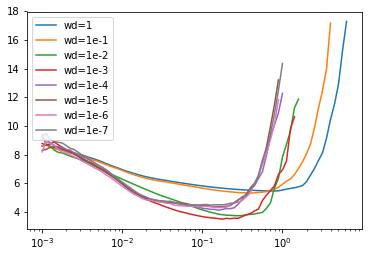

In [63]:
fig, ax = plt.subplots(1,1)
ax.plot(lrsw0[:-1],trn_lossesw0[:-1], label='wd=1')
ax.plot(lrsw1[:-1],trn_lossesw1[:-1], label='wd=1e-1')
ax.plot(lrsw2[:-1],trn_lossesw2[:-1], label='wd=1e-2')
ax.plot(lrsw3[:-1],trn_lossesw3[:-1], label='wd=1e-3')
ax.plot(lrsw4[:-1],trn_lossesw4[:-1], label='wd=1e-4')
ax.plot(lrsw5[:-1],trn_lossesw5[:-1], label='wd=1e-5')
ax.plot(lrsw6[:-1],trn_lossesw6[:-1], label='wd=1e-6')
ax.plot(lrsw7[:-1],trn_lossesw7[:-1], label='wd=1e-7')
ax.set_xscale('log')
ax.legend(loc='upper left')

#### lr = 0.01

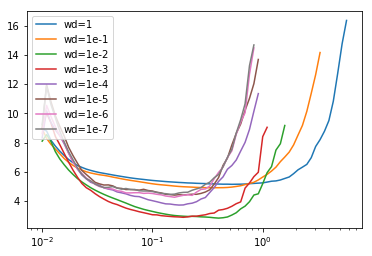

In [53]:
fig, ax = plt.subplots(1,1)
ax.plot(lrsw0[:-1],trn_lossesw0[:-1], label='wd=1')
ax.plot(lrsw1[:-1],trn_lossesw1[:-1], label='wd=1e-1')
ax.plot(lrsw2[:-1],trn_lossesw2[:-1], label='wd=1e-2')
ax.plot(lrsw3[:-1],trn_lossesw3[:-1], label='wd=1e-3')
ax.plot(lrsw4[:-1],trn_lossesw4[:-1], label='wd=1e-4')
ax.plot(lrsw5[:-1],trn_lossesw5[:-1], label='wd=1e-5')
ax.plot(lrsw6[:-1],trn_lossesw6[:-1], label='wd=1e-6')
ax.plot(lrsw7[:-1],trn_lossesw7[:-1], label='wd=1e-7')
ax.set_xscale('log')
ax.legend(loc='upper left')

# Train model

## 1 Cycle Training

### Single fold test training

In [18]:
sz = 256
bs = 16
k=3

learn = get_fold_model(sz, bs, k)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [19]:
lr = 1e-3
lrs = [lr/10, lr/3, lr]
wd = 1e-6

In [23]:
learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr_beta=(5,5,0.85,0.9), 
          use_wd_sched=True)

epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.355225   1.200827   0.94789    1.467102  
    1      1.276289   1.183555   0.948078   1.437518          
    2      1.194475   1.147568   0.949124   1.428948          
    3      1.184647   1.125764   0.949518   1.43281           
    4      1.141201   1.103412   0.950288   1.440947          



[1.1034119812647503, 0.9502881091416128, 1.4409472741805966]

In [24]:
learn.save('SENet_fold1_256')

In [22]:
sz = 256
bs = 12
k=3

learn = get_fold_model(sz, bs, k)
learn.load('SENet_fold1_256')
learn.unfreeze()

learn.fit(lrs, 1, wds=wd, cycle_len=30, use_clr_beta=(20,8,0.85,0.9), 
          use_wd_sched=True, best_save_name = 'SENet_fold1_256best')

learn.save('SENet_fold1_256')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


FileNotFoundError: [Errno 2] No such file or directory: './models/SENet_fold1_256.h5'

In [24]:
sz = 512
bs = 6
k = 3

learn = get_fold_model(sz, bs, k)
#######
learn.load('SENet_fold1_256best')
#######

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [23]:
lr = 1e-3
wd = 1e-6

In [24]:
learn.freeze_to(1)
learn.fit(lr, 1, wds=wd, cycle_len=10, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = 'SENet_fold1_512ph1best')

epoch      trn_loss   val_loss   acc        f1_metric_draft   
    0      1.635185   1.306851   0.945895   1.428848  
    1      1.339232   1.222341   0.946195   1.45316           
    2      1.308553   1.210869   0.946414   1.454463          
    3      1.253504   1.203736   0.946576   1.461752          
    4      1.231516   1.192213   0.947222   1.463193          
    5      1.219827   1.180207   0.947516   1.469153          
    6      1.207877   1.170534   0.947585   1.477804          
    7      1.203609   1.161623   0.947603   1.463775          
    8      1.19709    1.152697   0.948214   1.468944          
    9      1.182438   1.153161   0.948052   1.476829          



[1.1531611120463996, 0.9480524860374224, 1.4768285578430576]

In [25]:
learn.save('SENet_fold1_512ph1')

In [26]:
sz = 512
bs = 3
k=3

learn = get_fold_model(sz, bs, k)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


### Dropout = 0.5

In [28]:
#dropout = 0.5
learn.load('SENet_fold1_512ph1best')
learn.unfreeze()

learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(20,8,0.85,0.9), 
          use_wd_sched=True, best_save_name = 'SENet_fold1_512ph2best')

learn.save('SENet_fold1_512ph2')

epoch      trn_loss   val_loss   acc        f1_metric_draft     
    0      1.195386   1.154299   0.948566   1.449116  
    1      1.185978   1.100068   0.951312   1.470633            
    2      1.157019   1.061794   0.952339   1.427172            
    3      1.142938   1.0183     0.953619   1.420103            
    4      1.147917   0.997931   0.953689   1.415276            
    5      1.099308   0.989217   0.95464    1.409018            
    6      1.1767     0.992797   0.954952   1.369256            
    7      1.174156   1.064481   0.954883   1.433371             
    8      1.087807   1.705843   0.937969   1.432324             
    9      1.067088   0.9228     0.95625    1.35658              
    10     1.02679    4.229386   0.937507   1.388223             
    11     0.999423   14.268394  0.945226   1.2603               
    12     1.018907   4.659558   0.954231   1.26447              
    13     1.008414   12.265452  0.948404   1.309014             
    14     0.967476   51.163

# Regular

In [22]:
sz = 512
bs = 3
k=3

learn = get_fold_model(sz, bs, k)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [24]:
lr = 1e-3
lrs = np.array([lr/100, lr/10, lr])
wd = 1e-6

In [24]:
learn.load('SENet_fold1_512ph2best')
learn.unfreeze()
learn.fit(lrs/3,1,cycle_len=8,use_clr=(5,20))

learn.save('SENet_fold1_512ph2')

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      1.040346   0.930178   0.957179   1.362374  
    1      1.025065   0.896387   0.958846   1.364672             
    2      0.987952   1.646651   0.954617   1.341919             
    3      1.014934   0.924071   0.959082   1.325756             
    4      1.00964    1.51612    0.954473   1.311144             
    5      0.969583   0.849679   0.961805   1.319382             
    6      0.950104   0.864051   0.960934   1.314768             
    7      0.930829   0.822303   0.962763   1.320338             



In [24]:
learn.load('SENet_fold1_512ph2')
learn.fit(lrs/9,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft    
    0      0.856153   0.83789    0.963772   1.295016  
    1      0.790492   1.05494    0.961419   1.453501           
    2      0.799811   0.804136   0.964055   1.287577           
    3      0.852777   2.229052   0.953787   1.173408           
    4      0.903294   1.573117   0.956977   1.270058           
    5      0.838535   0.933996   0.962855   1.267775           
    6      0.84849    1.156798   0.957461   1.323071           
    7      0.923372   0.897175   0.96248    1.294088           



[0.8971745470261039, 0.9624801178853475, 1.2940878680629042]

# Changed $\gamma = 3$ & 1 Cycle

In [22]:
sz = 512
bs = 3
k=3

learn = get_fold_model(sz, bs, k)

lr = 1e-3
lrs = np.array([lr/100, lr/10, lr])
wd = 1e-6

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [23]:
learn.load('SENet_fold1_512ph2')
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=30, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = 'SENet_fold1_512ph2best')

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.479888   1.673726   0.956371   1.41211   
    1      0.479696   2.472331   0.935448   1.481965             
    2      0.467014   2.563482   0.95389    1.358991             
    3      0.470259   1.051017   0.96004    1.395756             
    4      0.45924    9.21734    0.938459   1.478793             
    5      0.511939   0.983704   0.959907   1.424301             
    6      0.451433   2.415893   0.948047   1.366002             
    7      0.449615   23.424889  0.929402   1.213827             
    8      0.519321   9.788134   0.901205   0.933945             
    9      0.481065   24.545623  0.934652   1.247843             
    10     0.518466   15.688163  0.916076   1.198524             
    11     0.48673    100.847126 0.881008   1.221324             
    12     0.50079    122.011273 0.888975   1.253042             
    13     0.482197   60.593022  0.905785   1.253509             
    14     0.477757  

KeyboardInterrupt: 

# Change $\gamma=1$ & 1 Cycle

In [22]:
sz = 512
bs = 3
k=3

learn = get_fold_model(sz, bs, k)
learn.crit = FocalLoss(gamma=1)

lr = 3e-4
lrs = np.array([lr/10, lr/3, lr])
wd = 1e-6

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [23]:
learn.load('SENet_fold1_512ph2')
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=30, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = 'SENet_fold1_512ph2best')

epoch      trn_loss   val_loss   acc        f1_metric_draft     
    0      1.70201    2.62115    0.954352   1.193312  
    1      1.581821   3.046643   0.953008   1.176386            
    2      1.68298    3.473752   0.952004   1.28539             
    3      1.616522   1.973158   0.960951   1.177373            
    4      1.747618   1.99091    0.960974   1.173032            
    5      1.710429   1.956707   0.959717   1.167828            
    6      1.696348   1.873299   0.961517   1.161195            
    7      1.46572    1.999152   0.961603   1.171315            
    8      1.532543   1.507758   0.963282   1.160576            
    9      1.662319   2.397797   0.953175   1.173304            
    10     1.66042    1.723783   0.962434   1.154873            
    11     1.613974   2.105894   0.960311   1.150836            
  1%|▏         | 120/8293 [01:34<1:47:25,  1.27it/s, loss=1.6] 

KeyboardInterrupt: 

# $\gamma=2$ and multi-cycle

In [23]:
sz = 512
bs = 3
k=3

learn = get_fold_model(sz, bs, k)
learn.crit = FocalLoss(gamma=2)

lr = 3e-4
lrs = np.array([lr/10, lr/3, lr])
wd = 1e-6

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [26]:
learn.load('SENet_fold1_512ph2')
learn.unfreeze()
learn.fit(lrs/3,2,cycle_len=6,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.900667   1.690346   0.951975   1.274897  
    1      0.906199   14.625019  0.891698   1.225686             
    2      0.873324   4.1012     0.948774   1.236577             
    3      0.858451   3.526113   0.950193   1.304077             
    4      0.873002   2.083795   0.954196   1.257382             
    5      0.920067   2.310742   0.953492   1.269695             
    6      0.84116    6.675999   0.939792   -4.48596             
    7      0.923493   12.021847  0.931738   1.315856             
    8      0.876977   3.8294     0.947481   1.232671             
    9      0.872477   8.096625   0.937813   1.23517              
    10     0.871422   3.076619   0.952852   1.231186             
    11     0.897582   4.279801   0.947285   1.208763             



[4.2798007559569795, 0.9472852479591256, 1.2087627074411498]

In [27]:
learn.fit(lrs/3,2,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.888881   10.910938  0.92218    1.285544  
    1      0.879246   11.78959   0.931162   1.224129             
    2      0.894956   3.793159   0.945376   1.226499             
    3      0.85542    7.267203   0.932125   1.17079              
    4      0.797291   6.017274   0.947718   1.249866             
    5      0.845645   3.492782   0.95494    1.202907             
    6      0.785267   27.007407  0.91006    1.101145             
    7      0.77295    1.74635    0.958211   1.268156             
    8      0.885417   3.050744   0.957282   1.265569             
    9      0.875977   10.05791   0.937698   1.218181             
    10     0.864124   5.794135   0.952137   1.216368             
    11     0.783475   13.077275  0.942457   1.284129             
    12     0.773177   7.945813   0.941436   1.22506              
    13     0.824266   30.596842  0.909846   1.223663             
    14     0.743267  

[11.164142641967409, 0.9341152081281991, 1.1431475477878312]

In [28]:
learn.fit(lrs,1,cycle_len=13,use_clr=(20,10))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.79971    2.979837   0.957017   1.243358  
    1      0.86737    11.960863  0.937801   1.257522             
    2      0.933376   29.956793  0.928906   1.237912             
    3      0.860848   43.525608  0.928416   1.275124             
    4      0.855908   50.537762  0.915251   1.163418             
    5      0.958258   9.351781   0.94188    1.162489             
    6      0.82437    83.504128  0.918355   1.166803             
    7      0.839393   50.919714  0.917847   1.154811             
    8      0.802836   40.63021   0.917703   1.166036             
 73%|███████▎  | 6082/8293 [1:12:27<26:20,  1.40it/s, loss=0.791]

KeyboardInterrupt: 

# Tune LRs divide by 10,10,1 instead of 10,3

In [24]:
sz = 512
bs = 3
k=3

learn = get_fold_model(sz, bs, k)
learn.crit = FocalLoss(gamma=2)

lr = 1e-4 #not 3e-4
lrs = np.array([lr/100, lr/10, lr])
wd = 1e-6

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [25]:
learn.load('SENet_fold1_512ph2')
learn.unfreeze()
learn.fit(lrs,2,cycle_len=6,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.850603   2.500917   0.951871   1.269703  
    1      0.843186   2.662967   0.936325   1.251846             
    2      0.890634   3.783778   0.938615   0.812666             
    3      0.850956   1.93208    0.957248   1.261615             
    4      0.848203   2.105357   0.948964   1.300564             
    5      0.904918   1.683857   0.954012   1.288208             
    6      0.846435   2.141428   0.95231    1.237705             
    7      0.880704   3.181851   0.951594   1.312595             
    8      0.825193   2.979467   0.942336   1.287574             
    9      0.85097    14.644449  0.911334   1.258593             
    10     0.857164   16.631629  0.912257   1.192192             
    11     0.92275    3.417822   0.933608   1.200885             



[3.417821964050144, 0.9336075585746473, 1.2008845902025036]

In [ ]:
learn.save('SENet_fold1_512ph3')

In [ ]:
learn.fit(lrs/16,1,cycle_len=20,use_clr=(5,20))

In [ ]:
learn.optim = optim.SGD

In [37]:
pred = make_prediction()

In [38]:
save_pred(pred, 0.5, fname='protein_181114.csv')
save_pred(pred, th_t, fname='protein_tht_181114.csv')

# Multi-fold Testing

In [39]:
for k in range(folds):
    print(f'Fold: {k}')
    sz = 256
    bs = 12

    lr = 1e-3
    lrs = [lr/100, lr/10, lr]
    wd = 1e-6

    learn = get_fold_model(sz, bs, k)
    learn.freeze_to(1)
    learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = f'SENet-fold{k}_{sz}ph1best')

    learn.unfreeze()
    learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = f'SENet-fold{k}_{sz}ph2best')
    
    learn.save(f'SENet-fold{k}_{sz}ph2')

Fold: 0


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.370845   1.231101   0.946706   1.470032  
    1      1.308536   1.205005   0.946895   1.446226          
    2      1.262536   1.187495   0.947165   1.439899          
    3      1.221182   1.1728     0.948115   1.441474          
    4      1.212334   1.167585   0.948001   1.44231           
    5      1.20329    1.16541    0.948293   1.430956          
    6      1.19339    1.156367   0.948322   1.434085          
    7      1.189346   1.155934   0.94811    1.441194          
    8      1.214504   1.146886   0.948471   1.451897          
    9      1.187833   1.144715   0.948969   1.443882          
    10     1.161494   1.132114   0.948929   1.439105          
    11     1.143145   1.12866    0.949421   1.414741          
    12     1.16241    1.12097    0.949118   1.418142          
    13     1.188246   1.121642   0.949502   1.424838          
    14     1.142856   1.120599   0.950029   1.393103          


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.123318   1.081025   0.952079   1.424892  
    1      1.017848   0.995748   0.954726   1.402434          
    2      0.955918   0.920405   0.957418   1.350606           
    3      0.881668   0.870463   0.95972    1.326572           
    4      0.846549   0.815095   0.961754   1.295843           
    5      0.864798   0.785198   0.963278   1.287965           
    6      0.77852    0.759411   0.964188   1.269458           
    7      0.789183   0.741015   0.964876   1.265653           
    8      0.75297    0.717477   0.966417   1.251363           
    9      0.72168    0.701268   0.967092   1.235786           
    10     0.666901   0.709293   0.96727    1.219326           
    11     0.612666   0.688393   0.968238   1.208658           
    12     0.620493   0.690104   0.968524   1.19814            
    13     0.538813   0.689871   0.968805   1.186505           
    14     0.5507     0.693568   0.968862   1.18377

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.408227   1.233573   0.946924   1.468213  
    1      1.31828    1.197895   0.947149   1.451596          
    2      1.267241   1.186462   0.94731    1.426999          
    3      1.234899   1.177736   0.947299   1.430166          
    4      1.209364   1.171863   0.947627   1.423482          
    5      1.205668   1.165671   0.947627   1.426186          
    6      1.208165   1.16628    0.948515   1.437433          
    7      1.194856   1.156249   0.948659   1.435122          
    8      1.207919   1.156521   0.948013   1.449485          
    9      1.171883   1.14058    0.948785   1.417703          
    10     1.169089   1.133322   0.948878   1.436604          
    11     1.187558   1.129779   0.949252   1.432001          
    12     1.145877   1.133302   0.949592   1.405471          
    13     1.13236    1.123298   0.94969    1.388212          
    14     1.115999   1.120017   0.949627   1.383412          


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.106762   1.082312   0.952122   1.401642  
    1      1.072649   1.00043    0.954934   1.396936          
    2      0.982436   0.919979   0.957504   1.355995           
    3      0.944386   0.856612   0.960707   1.330899           
    4      0.88493    0.818822   0.96224    1.295706           
    5      0.82509    0.785223   0.963565   1.293434           
    6      0.808733   0.754792   0.964706   1.278929           
    7      0.759975   0.732      0.965605   1.272484           
    8      0.711933   0.714002   0.967224   1.242071           
    9      0.693687   0.705111   0.966896   1.242447           
    10     0.712225   0.69395    0.967922   1.222516           
    11     0.623733   0.690194   0.968048   1.211483           
    12     0.599868   0.690196   0.967605   1.205735           
    13     0.562567   0.688216   0.968924   1.19418            
    14     0.565706   0.692276   0.968728   1.18805

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.404787   1.24369    0.946177   1.464535  
    1      1.30005    1.201198   0.947601   1.444565          
    2      1.204527   1.189243   0.94751    1.430301          
    3      1.249154   1.169181   0.947841   1.454786          
    4      1.228572   1.163697   0.94799    1.425881          
    5      1.228386   1.161931   0.948145   1.450308          
    6      1.186875   1.163121   0.948253   1.423286          
    7      1.187902   1.150704   0.948471   1.443986          
    8      1.18598    1.149403   0.948247   1.46001           
    9      1.166086   1.134561   0.948894   1.419276          
    10     1.194886   1.128082   0.949517   1.4342            
    11     1.155217   1.120993   0.949191   1.43522           
    12     1.150781   1.117701   0.949746   1.408118          
    13     1.157562   1.113378   0.94974    1.419707          
    14     1.131032   1.106998   0.950135   1.414022          


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.117718   1.075868   0.952028   1.421703  
    1      1.058174   0.987096   0.955334   1.39468           
    2      0.985263   0.908728   0.95816    1.364834           
    3      0.930899   0.848135   0.961048   1.339212           
    4      0.905292   0.804664   0.963062   1.296254           
    5      0.834324   0.777769   0.963862   1.281365           
    6      0.808744   0.753357   0.964572   1.262827           
    7      0.782201   0.722366   0.966127   1.272552           
    8      0.749761   0.710817   0.966797   1.249002           
    9      0.705111   0.691313   0.9675     1.236306           
    10     0.675049   0.678497   0.968393   1.231569           
    11     0.641351   0.679167   0.968324   1.209504           
    12     0.595634   0.681255   0.968381   1.203246           
    13     0.569298   0.688685   0.968804   1.180495           
    14     0.582523   0.675916   0.969571   1.17721

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.372525   1.243037   0.946241   1.46588   
    1      1.275679   1.212891   0.947268   1.437725          
    2      1.253498   1.195631   0.947429   1.427636          
    3      1.252481   1.185501   0.947533   1.435962          
    4      1.242301   1.176296   0.947441   1.445286          
    5      1.201256   1.168444   0.947926   1.423306          
    6      1.2197     1.16129    0.94826    1.427586          
    7      1.188316   1.160322   0.947949   1.430776          
    8      1.208059   1.154925   0.948156   1.451766          
    9      1.152582   1.152034   0.948647   1.403708          
    10     1.163588   1.138109   0.948606   1.424242          
    11     1.143605   1.132382   0.94886    1.407113          
    12     1.162237   1.131209   0.948964   1.403264          
    13     1.118708   1.121512   0.94942    1.395775          
    14     1.119531   1.130269   0.94897    1.403025          


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.141116   1.080194   0.952246   1.413517  
    1      1.037048   0.993798   0.955096   1.385888          
    2      0.961041   0.911589   0.957871   1.361742           
    3      0.885193   0.858446   0.96023    1.308305           
    4      0.835184   0.820181   0.962076   1.29844            
    5      0.864463   0.775288   0.963801   1.305967           
    6      0.801273   0.751181   0.964626   1.269369           
    7      0.763506   0.734891   0.965157   1.257391           
    8      0.726601   0.718212   0.965907   1.25008            
    9      0.720297   0.70015    0.966945   1.236471           
    10     0.692918   0.68859    0.967978   1.218548           
    11     0.625922   0.680639   0.96822    1.208465           
    12     0.594897   0.67523    0.969189   1.192273           
    13     0.586638   0.677032   0.969218   1.18548            
    14     0.549482   0.676181   0.969881   1.18101

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.391711   1.248727   0.945769   1.459597  
    1      1.29306    1.205425   0.946469   1.443744          
    2      1.25489    1.189092   0.946544   1.423393          
    3      1.23888    1.187267   0.947666   1.426019          
    4      1.243008   1.17341    0.947337   1.451668          
    5      1.203539   1.173667   0.947499   1.422742          
    6      1.210127   1.163106   0.947198   1.439157          
    7      1.215291   1.164091   0.947707   1.459615          
    8      1.192295   1.15884    0.94784    1.424548          
    9      1.19765    1.148341   0.948291   1.437622          
    10     1.127683   1.135318   0.94839    1.415242          
    11     1.18273    1.132874   0.948667   1.449837          
    12     1.158054   1.126893   0.948731   1.421128          
    13     1.124269   1.122948   0.948847   1.418646          
    14     1.12753    1.115585   0.949483   1.398868          


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.117728   1.081853   0.951785   1.430622  
    1      1.019782   0.990037   0.954828   1.40229            
    2      0.983965   0.91845    0.957524   1.371339           
    3      0.911063   0.853037   0.960254   1.337606           
    4      0.859622   0.817346   0.961509   1.319578           
    5      0.823068   0.787395   0.962782   1.291393           
    6      0.821641   0.761164   0.964245   1.27511            
    7      0.792737   0.746048   0.964905   1.273027           
    8      0.726236   0.731827   0.965194   1.247789           
    9      0.721434   0.697786   0.967566   1.240085           
    10     0.647305   0.700615   0.967138   1.216432           
    11     0.614575   0.692971   0.967294   1.215231           
    12     0.593555   0.679334   0.968786   1.211208           
    13     0.568974   0.690773   0.968549   1.192059           
    14     0.525157   0.686305   0.968989   1.1845

## Refining single fold schedule

In [21]:
k = 3
sz = 512
bs = 3

lr = 3e-4
wd = 1e-6

learn = get_fold_model(sz, bs, k)
learn.load(f'SENet-fold{k}_256ph2')

learn.freeze_to(1)
learn.fit(lr, 1)

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric_draft    
    0      0.901354   0.767956   0.963576   1.29451   



[0.7679559779155622, 0.9635761777335271, 1.2945103393658512]

In [22]:
learn.save(f'SENet-fold{k}_{sz}ph3')

In [23]:
learn.load(f'SENet-fold{k}_{sz}ph3')
lrs=np.array([lr/10,lr/3,lr])
learn.unfreeze()
learn.fit(lrs/4,1,cycle_len=8,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.943029   0.819658   0.961459   1.269097  
    1      0.924096   0.806195   0.961938   1.283483             
    2      0.899001   0.770062   0.963813   1.269651             
    3      0.990509   0.786216   0.963986   1.263134             
    4      0.908328   0.796226   0.962111   1.261164             
    5      0.88664    0.755927   0.965209   1.248166             
    6      0.892813   0.74168    0.965578   1.258988             
    7      0.899579   0.801596   0.963668   1.274654             



[0.801595607848588, 0.9636684783035325, 1.2746535588727979]

In [24]:
learn.save(f'SENet-fold{k}_{sz}ph4')

In [25]:
learn.load(f'SENet-fold{k}_{sz}ph4')
learn.fit(lrs/4,1,cycle_len=8,use_clr=(10,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.946055   0.765179   0.964349   1.257012  
    1      0.929001   0.775015   0.96413    1.273006             
    2      0.948813   0.773229   0.964159   1.268387             
    3      0.962262   0.753645   0.965463   1.250824             
    4      0.914437   13.015711  0.932967   1.276011             
    5      0.860237   0.740831   0.966184   1.231832             
    6      0.878519   1.640328   0.955442   1.264542             
    7      0.887815   1.341629   0.957282   1.147688             



[1.3416286093391812, 0.9572824802369414, 1.1476882694274346]

In [26]:
learn.save(f'SENet-fold{k}_{sz}ph5')

In [27]:
learn.load(f'SENet-fold{k}_{sz}ph5')
learn.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.937092   10.577226  0.934634   1.231223  
    1      0.884809   0.733182   0.967014   1.229456             
    2      0.832022   0.737469   0.966461   1.242525             
    3      0.873715   0.741901   0.96698    1.22554              
    4      0.866342   2.027813   0.949218   1.231287             
    5      0.83847    5.16615    0.947331   0.824365             
    6      0.887878   0.710965   0.967689   1.259648             
    7      0.762397   0.721794   0.96706    1.244703             



[0.7217936700793951, 0.9670604997777993, 1.2447033282763507]

In [28]:
learn.fit(lrs/20,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.776929   0.735255   0.966887   1.239972  
    1      0.870943   1.064387   0.961136   1.244577             
    2      0.892674   0.74372    0.966587   1.224828             
    3      0.833467   0.716698   0.967562   1.239771             
    4      0.793756   5.549979   0.946287   1.219033             
    5      0.824853   0.733535   0.966928   1.22992              
    6      0.800437   0.714418   0.968076   1.234579             
    7      0.851103   0.702539   0.968191   1.227813             



[0.7025386863758936, 0.9681911740871455, 1.227813230040693]

# Continue 1 Cycle 

In [23]:
for k in range(folds):
    print(f'Fold: {k}')
    sz = 512
    bs = 3

    lr = 1e-4
    lrs = [lr/10, lr/3, lr]
    wd = 1e-6

    learn = get_fold_model(sz, bs, k)
    learn.load(f'SENet-fold{k}_256ph2')
    
    learn.unfreeze()
    learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(20,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = f'SENet-fold{k}_{sz}ph2best')

Fold: 0


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  5%|▍         | 408/8279 [05:16<1:41:44,  1.29it/s, loss=1.23]

KeyboardInterrupt: 

In [31]:
def get_senet_model(md):
    learn = SENetLearner.pretrained(senet154, md, ps=0.2, xtra_fc=None) #dropout 50%
    learn.opt_fn = optim.Adam
    learn.crit = FocalLoss()
    learn.metrics = [acc, f1_metric_draft]
    learn.clip = 0.06
    return learn 

In [ ]:
for k in range(folds):
    print(f'Fold: {k}')
    sz = 512
    bs = 3

    lr = 1e-4
    lrs = [lr/10, lr/3, lr]
    wd = 1e-6

    learn = get_fold_model(sz, bs, k)
    learn.load(f'SENet-fold{k}_256ph2')

    learn.freeze_to(1)
    learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = f'SENet-fold{k}_{sz}ph1best')

    learn.unfreeze()
    learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(10,10,0.85,0.9), 
          use_wd_sched=True, best_save_name = f'SENet-fold{k}_{sz}ph2best')

Fold: 0


/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric_draft    
    0      0.834805   0.765837   0.965242   1.237594  
    1      0.900765   0.732235   0.966325   1.231256           
    2      0.902895   0.719371   0.967408   1.230688           
    3      0.82627    0.7148     0.967425   1.229078           
    4      0.824123   0.713376   0.966273   1.237911           
    5      0.878144   0.751207   0.966079   1.235257           
    6      0.911209   1.551236   0.959657   1.22177            
    7      0.884188   3.129074   0.960362   1.236892           
    8      0.857278   17.06925   0.950126   1.158007           
    9      0.778393   23.464521  0.932696   1.169817           
    10     0.901535   31.223499  0.940486   1.146159           
    11     0.834648   21.916193  0.946873   1.154175           
    12     0.844259   23.726695  0.945904   1.160805           
    13     0.862336   19.722453  0.942823   1.194404           
    14     0.807842   44.63285   0.936161   1.145

epoch      trn_loss   val_loss   acc        f1_metric_draft      
    0      0.92432    42.160392  0.924722   1.133657  
    1      0.854646   59.591305  0.919321   1.081914             
    2      0.834882   59.881081  0.928159   1.199587             
    3      0.845546   210.009967 0.90515    1.090238             
Validation:  93%|█████████▎| 1927/2079 [07:39<00:36,  4.19it/s]  

12th Nov 
1. Started to overfit at epoch 20/21 for the 256x256 training. (lr = 1e-3, wd = 1e-7, clip = 0.06)
    1. Ideas:
        1. Try to tune weight decay
        1. Add more dropout to CNN outputs
        1. Increase weight decay
    1. Accuracy continued to increase independent of validation loss - perhaps, the model couldn't generalise to rare classes?
1. Wrote a proper F1 score above

1. Started the 512x512 loop - 56 hours to complete

13th Nov
1. 512x512 seems to be failing to converge - loss was just fluctuating around a set point. 
    1. Ideas:
        1. Try reducing the learning rate further - changed [10,3,1] to [100,10,1], this seems to be performing better
        1. Plot training VS validation losses to visualise better
        1. Use cyclic jumps rather than 1 cycle
1. Do we need to increase number of epochs on the first run? Gugger's work used 70 epochs
1. For the next fold:
    1. Train the 256x256 frozen longer - 20 epochs. 
    1. Train the 256x256 unfrozen shorter - 23 epochs
    1. Train the 512x512 head frozen model longer - 20 epochs
    1. Train the whole longer - 60 epochs, Start the cycle on all folds before Phuket trip *
    1. Reduce the cylic increase ie. instead of x20, make it x10. Maybe that's why the val loss explodes in the middle?
1. Question: is it worth unfreezing the rest of the model? Remember the initial salt model performed better with the only the head

## Overfold Experiments

In [216]:
lr = 3e-3
wd = 1e-7
nw=6
lrs=np.array([lr/10,lr/3,lr])

In [ ]:
sz = 128
bs = 24
for k in range(folds):
    learn = get_overfold_model(sz,bs,k)
    learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr_beta=(5,8,0.85,0.9), use_wd_sched=True)
    
    learn.unfreeze()
    
    learn.fit(lrs, 1, wds=wd, cycle_len=10, use_clr_beta=(20,10,0.85,0.9), use_wd_sched=True)
    learn.save(f'SEResNextFold_128_{k}')

In [203]:
sz = 256
bs = 16
for k in range(folds):
    learn = get_overfold_model(sz,bs,k)
    learn.load(f'SEResNextFold_128_{k}')
    learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr_beta=(5,5,0.85,0.9), use_wd_sched=True)
    
    learn.unfreeze()
    learn.bn_freeze(True)
    
    learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(20,8,0.85,0.9), use_wd_sched=True)
    learn.save(f'SEResNextFold_256_{k}')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric         
    0      1.287492   1.480285   0.933829   1.411398  
    1      1.190252   1.432211   0.936756   1.385831          
    2      1.07842    1.427014   0.938588   1.354518          
    3      1.050972   1.409981   0.939156   1.326916          
    4      0.941893   1.369003   0.942046   1.312287           
    5      0.877585   1.367926   0.942392   1.289273           
    6      0.863571   1.329484   0.944335   1.286037           
    7      0.830794   1.270952   0.94522    1.283957           
    8      0.795969   1.318031   0.945266   1.267977           
    9      0.800551   1.284401   0.945784   1.275932           


In [ ]:
sz = 512
bs = 8
for k in range(folds):
    learn = get_overfold_model(sz,bs,3)
    learn.load(f'SEResNextFold_256_{k}')
    learn.fit(lr, 1, wds=wd, cycle_len=8, use_clr_beta=(5,5,0.85,0.9), use_wd_sched=True)
    
    learn.unfreeze()
    learn.bn_freeze(True)
    
    learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr_beta=(20,8,0.85,0.9), use_wd_sched=True, best_save_name='SEResNextFold_512_3best')
    learn.save(f'SEResNextFold_512_{k}')

/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/eigenstir/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   acc        f1_metric          
    0      0.936123   1.493907   0.939811   1.257735  
    1      0.909803   1.498809   0.942874   1.244564           
    2      0.909558   1.519219   0.943788   1.222911           
    3      0.874937   1.512659   0.94534    1.212539           
    4      0.770423   1.367456   0.948469   1.219535           
    5      0.801867   1.5168     0.947616   1.199073           
    6      0.761069   1.317298   0.951853   1.197406           
    7      0.714581   1.306861   0.951408   1.199208           
    8      0.699356   1.419535   0.953409   1.186518           
    9      0.662387   1.282365   0.955352   1.191486           
    10     0.656751   1.251562   0.953623   1.178844           
    11     0.659572   1.137671   0.956575   1.189399           
    12     0.6996     1.205377   0.957271   1.179339           
    13     0.662278   1.083555   0.958654   1.178905           
    14     0.626937   1.007507   0.959074   1.192

In [ ]:
pred = make_prediction()
check_thresh(pred)

In [ ]:
save_pred(pred, th_t, fname=f'protein_class_3_oversample_tht.csv')
save_pred(pred, 0.5, fname=f'protein_class_3_oversample_0.5.csv')

# Submission Functions

In [35]:
def check_thresh(preds_y):
    thresholds = np.linspace(0, 1, 1500)
    score = 0.0
    best_threshold=0.0
    best_val = 0.0
    for threshold in thresholds:
        score = f1_score(valid_y > 0.5, preds_y > threshold, average='macro')
        if score > best_val:
            best_threshold = threshold
            best_val = score
        print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

    print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))

In [36]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

def make_prediction():
    preds,y = learn.TTA(n_aug=16, is_test=True)
    preds = np.stack(preds, axis=-1)
    preds = sigmoid_np(preds)
    pred = preds.max(axis=-1)
    return pred

def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learn.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))